<a href="https://colab.research.google.com/github/inf14/Anant-Jain---23FE10CSE00483---ML-LAB/blob/main/ML_LAB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:


#required packages
!pip install plotly pandas numpy scikit-learn missingno ipywidgets --quiet

#Imports
import os, zipfile
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from IPython.display import display, Markdown

# Config
SHOW_EDA = True
RANDOM_STATE = 42


# 1) Upload & extract dataset
print("Upload the ZIP file containing the Student performance dataset (the same zip you used before).")
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]
print(f"Uploaded file: {zip_path}")

extract_dir = '/content/superstore_dataset'
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Extracted to: {extract_dir}")

# find the first plausible data file (.csv, .xls, .xlsx)
possible_files = []
for root, _, files_list in os.walk(extract_dir):
    for fname in files_list:
        if fname.lower().endswith(('.xls', '.xlsx', '.csv')):
            possible_files.append(os.path.join(root, fname))

if not possible_files:
    raise FileNotFoundError("No .xls/.xlsx/.csv file found in the uploaded zip. Please upload the Student performnace zip that contains the dataset.")

print("Possible data files found:")
for i, p in enumerate(possible_files):
    print(i, p)

# choose first file by default (change index if you want another)
data_path = possible_files[0]
print(f"\nLoading data from: {data_path}")

# load the dataset
if data_path.lower().endswith('.csv'):
    df = pd.read_csv(data_path, low_memory=False)
else:
    df = pd.read_excel(data_path)

print("\nInitial dataset shape:", df.shape)
display(df.head())



Upload the ZIP file containing the Student performance dataset (the same zip you used before).


Saving archive (1).zip to archive (1) (1).zip
Uploaded file: archive (1) (1).zip
Extracted to: /content/superstore_dataset
Possible data files found:
0 /content/superstore_dataset/Student_Performance_Dataset.csv

Loading data from: /content/superstore_dataset/Student_Performance_Dataset.csv

Initial dataset shape: (5000, 16)


,Student_ID,Age,Gender,Class,Study_Hours_Per_Day,Attendance_Percentage,Parental_Education,Internet_Access,Extracurricular_Activities,Math_Score,Science_Score,English_Score,Previous_Year_Score,Final_Percentage,Performance_Level,Pass_Fail
0,S0001,15,Male,12,1.0,65,Postgraduate,No,No,40,39,72,81,50.33,Average,Pass
1,S0002,19,Female,9,1.6,58,Graduate,No,Yes,80,44,35,47,53.00,Average,Pass
2,S0003,14,Female,12,3.6,64,High School,Yes,Yes,83,73,59,58,71.67,Good,Pass
3,S0004,18,Female,9,5.5,68,Postgraduate,Yes,No,68,48,77,54,64.33,Average,Pass
4,S0005,14,Male,10,5.0,80,High School,Yes,No,41,46,36,68,41.00,Poor,Fail


In [3]:
df = df.copy()

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

print(df.columns.tolist())


['student_id', 'age', 'gender', 'class', 'study_hours_per_day', 'attendance_percentage', 'parental_education', 'internet_access', 'extracurricular_activities', 'math_score', 'science_score', 'english_score', 'previous_year_score', 'final_percentage', 'performance_level', 'pass_fail']


In [4]:
df.drop(columns=['student_id'], inplace=True)


In [5]:
print("Missing values per column:")
display(df.isnull().sum())


Missing values per column:


,0
age,0
gender,0
class,0
study_hours_per_day,0
attendance_percentage,0
parental_education,0
internet_access,0
extracurricular_activities,0
math_score,0
science_score,0


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


In [9]:
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


In [10]:
display(df.describe())


,age,gender,class,study_hours_per_day,attendance_percentage,parental_education,internet_access,extracurricular_activities,math_score,science_score,english_score,previous_year_score,final_percentage,performance_level,pass_fail
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,16.508800,0.489400,10.496400,3.287260,74.919800,1.003600,0.475600,0.503800,67.754800,66.895400,67.782800,67.282200,67.477656,1.154000,0.947000
std,1.718637,0.499938,1.106812,1.587979,14.673842,0.817386,0.499454,0.500036,18.724487,19.141195,19.248473,16.157511,10.964081,1.008408,0.224056
min,14.000000,0.000000,9.000000,0.500000,50.000000,0.000000,0.000000,0.000000,35.000000,35.000000,35.000000,40.000000,36.330000,0.000000,0.000000
25%,15.000000,0.000000,10.000000,1.900000,62.000000,0.000000,0.000000,0.000000,52.000000,50.000000,51.000000,53.000000,59.670000,0.000000,1.000000
50%,17.000000,0.000000,10.000000,3.300000,75.000000,1.000000,0.000000,1.000000,68.000000,67.000000,68.000000,67.000000,67.330000,1.000000,1.000000
75%,18.000000,1.000000,11.000000,4.700000,88.000000,2.000000,1.000000,1.000000,84.000000,83.000000,85.000000,81.000000,75.330000,2.000000,1.000000
max,19.000000,1.000000,12.000000,6.000000,100.000000,2.000000,1.000000,1.000000,100.000000,100.000000,100.000000,95.000000,98.330000,3.000000,1.000000


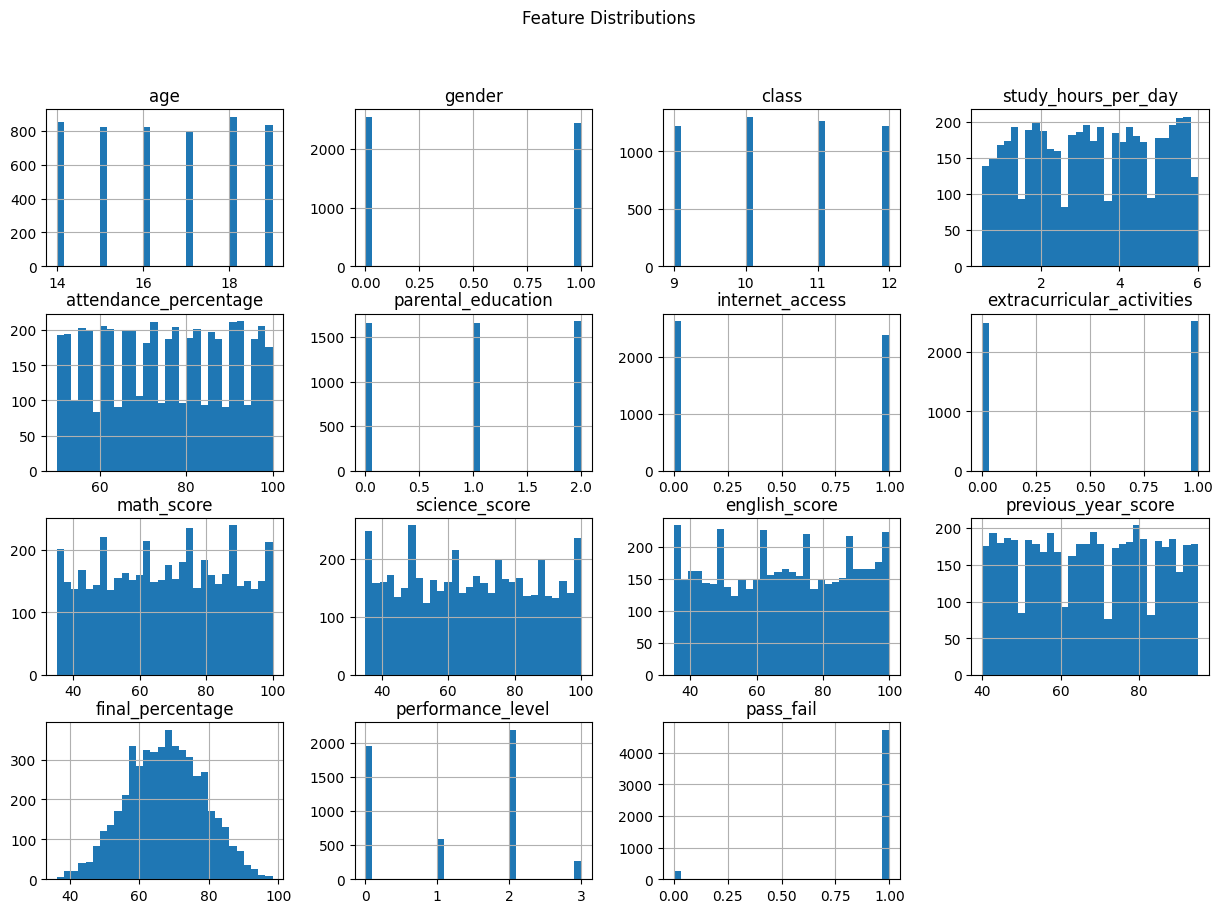

In [11]:
df.hist(figsize=(15,10), bins=30)
plt.suptitle("Feature Distributions")
plt.show()


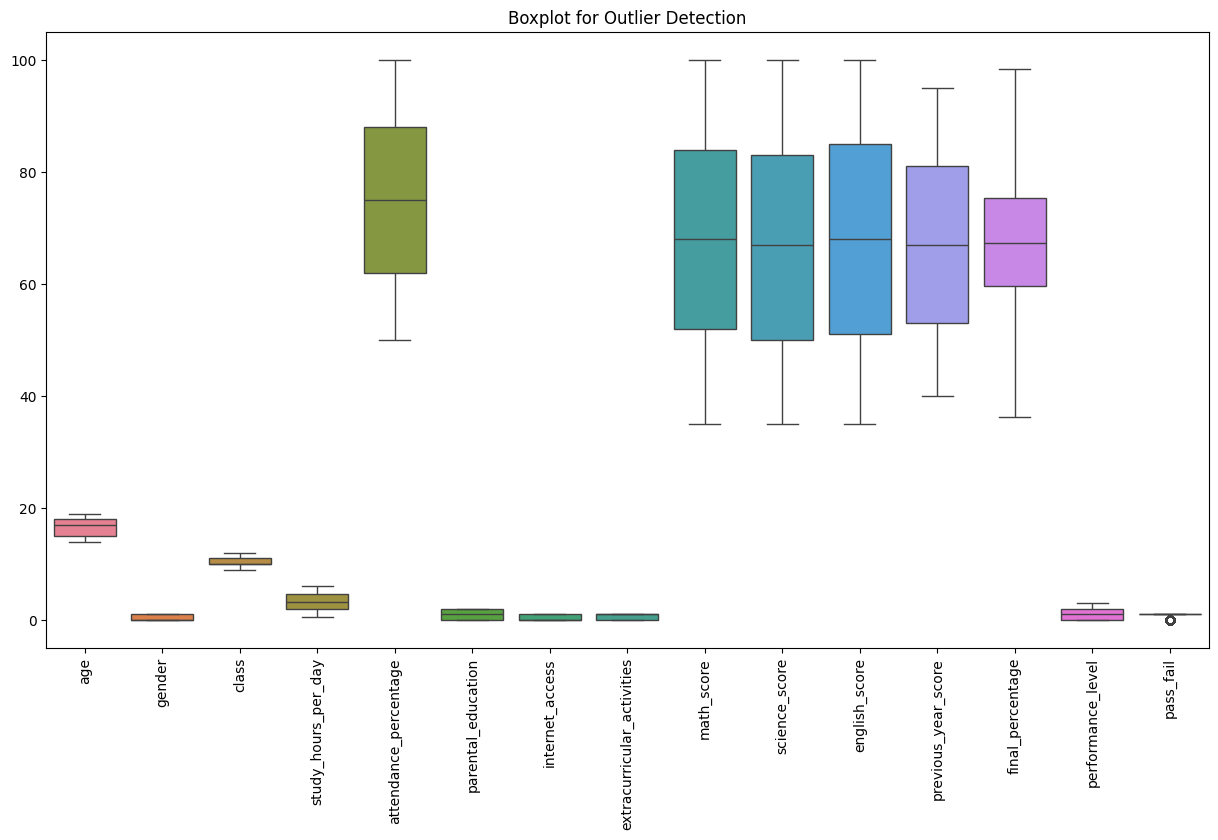

In [12]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot for Outlier Detection")
plt.show()


In [13]:
corr_matrix = df.corr()


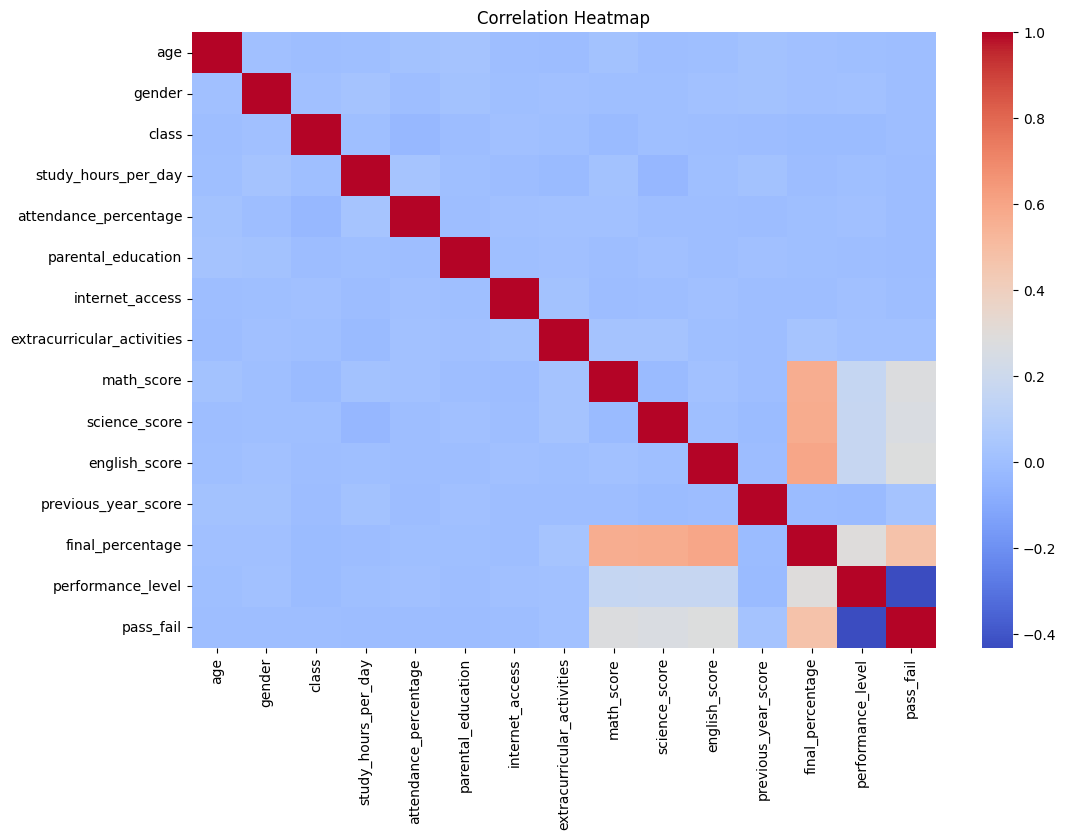

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


In [15]:
target_corr = corr_matrix['final_percentage'].sort_values(ascending=False)
display(target_corr)


,final_percentage
final_percentage,1.000000
english_score,0.591922
science_score,0.571914
math_score,0.563523
pass_fail,0.470437
performance_level,0.291675
extracurricular_activities,0.027572
age,0.005963
gender,0.005382
attendance_percentage,0.000796


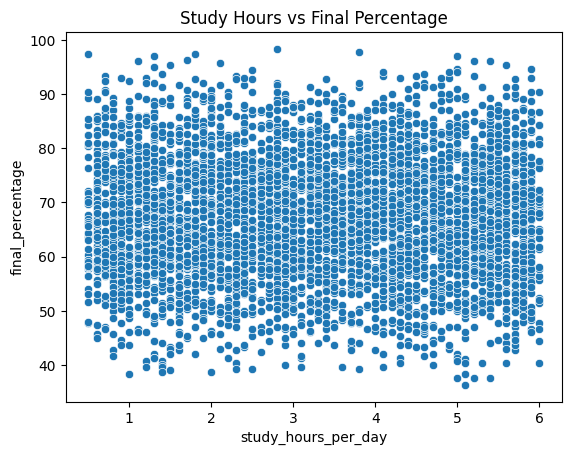

In [16]:
sns.scatterplot(
    x='study_hours_per_day',
    y='final_percentage',
    data=df
)
plt.title("Study Hours vs Final Percentage")
plt.show()


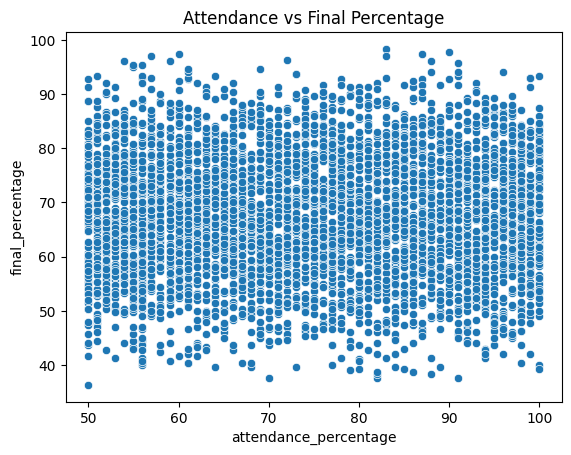

In [17]:
sns.scatterplot(
    x='attendance_percentage',
    y='final_percentage',
    data=df
)
plt.title("Attendance vs Final Percentage")
plt.show()


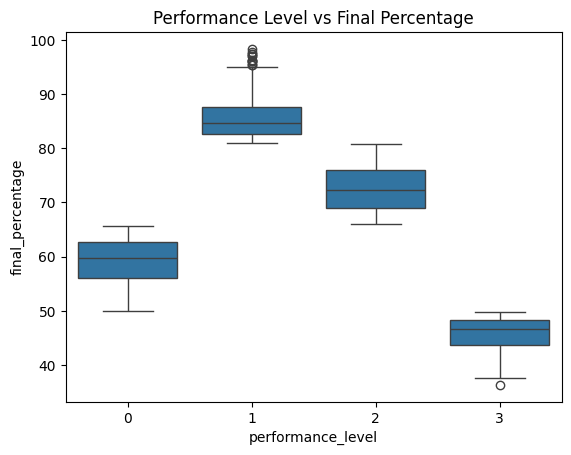

In [18]:
sns.boxplot(
    x='performance_level',
    y='final_percentage',
    data=df
)
plt.title("Performance Level vs Final Percentage")
plt.show()


In [19]:
X = df.drop(columns=['final_percentage'])
y = df['final_percentage']


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


In [21]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R2 Score: 0.9999999372490902
MAE: 0.002276795351295867
RMSE: 0.002730652343542611
